# 필요 라이브러리 호출

In [64]:
# 기폰 패키지
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parser
import time
import matplotlib.pyplot as plt

# 전처리 패키지
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# 모델 패키지
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras
from keras import models
from keras import layers

# 데이터 크롤링

In [6]:
# 셀레니움(selenium)으로 브라우저를 컨트를하기 위해서는 webdriver를 설치해야 한다
# 구글크롬은 chromedriver로 검색하면 exe파일을 다운로드 할 수 있다.
# webdriver 설치 위치를 정의한다.
browser = webdriver.Chrome('C:\Program Files (x86)\Google\Chrome\Application\chromedriver')

# 메이저리그 stats 크롤링
def crawling(url):
    # 셀레니움(selenium)으로 브라우저를 컨트를하기 위해서는 webdriver를 설치해야 한다
    # 구글크롬은 chromedriver로 검색하면 exe파일을 다운로드 할 수 있다.
    # webdriver 설치 위치를 정의한다.
    browser = webdriver.Chrome('C:\Program Files (x86)\Google\Chrome\Application\chromedriver')
    # 불러오고자하는 url을 .get으로 호출한다.
    browser.get(url)
    
    # page_source파라미터를 이용하면 HTML정보를 가지고 온다.
    html = browser.page_source
    soup = BeautifulSoup(html, 'html.parser')   # 뷰티풀숩으로 HTML을 파싱하고 필요한 데이터 수집
    table_tags = soup.find_all("table")   # find_all함수를 이용하면, TABLE태그로 지정된 곳만 뽑아서, 배열 형태로 저장
    table = table_tags[0]    # html상에서 table 순서, 첫번째 테이블 가지고 와야 함.
    p=parser.make2d(table)

    df_total=pd.DataFrame(p[1:],columns=p[0])    # 데이터 프레임으로 저장

    num = soup.find_all("button")[5].text   # 5번째 button에 페이지수 정보가 있음
    for j in range(1, int(num)):
        btn = browser.find_element_by_class_name('paginationWidget-next')
        btn.click()     # 버튼 클릭
        time.sleep(5)

        # 2페이지 이후 데이터 병합
        html = browser.page_source
        soup = BeautifulSoup(html, 'html.parser')
        table_tags = soup.find_all("table")
        table = table_tags[0]
        p = parser.make2d(table)

        df = pd.DataFrame(p[1:], columns=p[0])
        df_total = pd.concat([df_total, df], 0)
        
    return df_total
        # 엑셀로 다운로드
        # df_total.to_excel("test.xlsx")

# 마이너리그 stats 크롤링        
def crawling_miner(url):
    # 셀레니움(selenium)으로 브라우저를 컨트를하기 위해서는 webdriver를 설치해야 한다
    # 구글크롬은 chromedriver로 검색하면 exe파일을 다운로드 할 수 있다.
    # webdriver 설치 위치를 정의한다.
    browser = webdriver.Chrome('C:\Program Files (x86)\Google\Chrome\Application\chromedriver')
    # 불러오고자하는 url을 .get으로 호출한다.
    browser.get(url)
    
    # page_source파라미터를 이용하면 HTML정보를 가지고 온다.
    html = browser.page_source
    soup = BeautifulSoup(html, 'html.parser')   # 뷰티풀숩으로 HTML을 파싱하고 필요한 데이터 수집
    table_tags = soup.find_all("table")   # find_all함수를 이용하면, TABLE태그로 지정된 곳만 뽑아서, 배열 형태로 저장
    table = table_tags[0]    # html상에서 table 순서, 첫번째 테이블 가지고 와야 함.
    p=parser.make2d(table)

    df_total_miner=pd.DataFrame(p[1:],columns=p[0])    # 데이터 프레임으로 저장
    
    return df_total_miner

In [7]:
list_url = ["http://mlb.mlb.com/stats/sortable.jsp?c_id=mlb#elem=%5Bobject+Object%5D&tab_level=child&click_text=Sortable+Player+hitting&game_type='R'&season=2019&season_type=ANY&league_code='MLB'&sectionType=sp&statType=hitting&page=1&ts=1580532864437&playerType=ALL",
"http://www.milb.com/milb/stats/stats.jsp?sid=milb&t=l_bat&lid=117"]

df_total_hit_mlb = crawling(list_url[0])
df_total_hit_miner = crawling_miner(list_url[1])

# 데이터 전처리

In [8]:
# 컬럼 rename
df_total_hit_mlb = df_total_hit_mlb.rename(columns={'RK':'RK', 'Player':'Player', 'Team':'Team', 
                                            '':'del', '▲':'del2', 'Pos':'Pos', 'G▼':'G',
                                            'AB▼':'AB', 'R▼':'R',
                                            'H▼':'H', '2B▼':'2B', '3B▼':'3B', 'HR▼':'HR',
                                            'RBI▼':'RBI', 'BB▼':'BB', 'SO▼':'SO', 'SB▼':'SB',
                                            'CS▼':'CS', 'AVG▼':'AVG', 'OBP▼':'OBP',
                                            'SLG▼':'SLG', 'OPS▼':'OPS', 'IBB▼':'IBB',
                                            'HBP▼':'HBP', 'SAC▼':'SAC', 'SF▼':'SF', 
                                            'TB▼':'TB', 'XBH▼':'XBH', 'GDP▼':'GDP',
                                            'GO▼':'GO', 'AO▼':'AO', 'GO_AO▼':'GO_AO',
                                            'NP▼':'NP', 'PA▼':'PA'})
df_total_hit_miner = df_total_hit_miner.rename(columns={'NAME':'Player', 'TEAM':'Team',
                                            '':'del', '▲':'del2', 'POS':'Pos', 'G▼':'G',
                                            'AB▼':'AB', 'R▼':'R',
                                            'H▼':'H', '2B▼':'2B', '3B▼':'3B', 'HR▼':'HR',
                                            'RBI▼':'RBI', 'TB▼':'TB', 'BB▼':'BB', 'SO▼':'SO', 'SB▼':'SB',
                                            'CS▼':'CS', 'AVG▼':'AVG', 'OBP▼':'OBP',
                                            'SLG▼':'SLG', 'OPS▼':'OPS'})

In [9]:
df_total_hit_mlb.to_excel("df_total_hit_mlb.xlsx")
df_total_hit_mlb

,RK,Player,Team,del,del2,Pos,G,AB,R,H,...,SAC,SF,TB,XBH,GDP,GO,AO,GO_AO,NP,PA
0,1,"Alaniz, R",CIN,,595798,P,8,1,0,1,...,0,0,1,0,0,0,0,-.--,5,1
1,1,"Brebbia, J",STL,,605154,P,63,1,1,1,...,0,0,1,0,0,0,0,-.--,1,1
2,1,"Drake, O",TB,,543118,P,3,1,0,1,...,0,0,1,0,0,0,0,-.--,4,1
3,1,"Liriano, F",PIT,,434538,P,67,1,0,1,...,0,0,1,0,0,0,0,-.--,15,2
4,1,"Lugo, S",NYM,,607625,P,57,1,0,1,...,0,0,1,0,0,0,0,-.--,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,984,"Yates, K",SD,,489446,P,59,0,0,0,...,0,0,0,0,0,0,0,-.--,0,0
33,984,"Ynoa, G",BAL,,593679,P,4,0,0,0,...,0,0,0,0,0,0,0,-.--,0,0
34,984,"Ynoa, H",ATL,,660623,P,2,0,0,0,...,0,0,0,0,0,0,0,-.--,0,0
35,984,"Zamora, D",NYM,,623354,P,17,0,0,0,...,0,0,0,0,0,0,0,-.--,0,0


In [10]:
df_total_hit_miner.to_excel("df_total_hit_miner.xlsx")
df_total_hit_miner

,Player,del2,Team,Pos,G,AB,R,H,2B,3B,...,RBI,TB,BB,SO,SB,CS,OBP,SLG,AVG,OPS
0,Jake Cronenworth,630105,DUR,SS,88,344,75,115,26,4,...,45,179,49,62,12,5,.429,.520,.334,.949
1,Jake Elmore,518653,IND,2B,109,367,56,118,31,0,...,35,167,37,55,3,8,.387,.455,.322,.842
2,Ali Castillo,542419,LHV,3B,113,415,60,131,22,4,...,58,182,27,55,4,4,.353,.439,.316,.792
3,Ryan McBroom,643436,SWB,1B,117,413,87,130,29,0,...,66,237,58,100,2,2,.402,.574,.315,.976
4,Ryan Mountcastle,663624,NOR,1B,127,520,81,162,35,1,...,83,274,24,130,2,1,.344,.527,.312,.871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Blake Trahan,664167,LOU,SS,101,354,34,80,14,2,...,29,113,22,84,3,5,.279,.319,.226,.598
60,Eric Haase,606992,COL,C,102,350,67,79,12,3,...,60,181,42,142,1,1,.315,.517,.226,.832
61,Gorkys Hernandez,491676,PAW,CF,123,430,75,94,14,3,...,53,162,62,146,20,6,.319,.377,.219,.695
62,Daz Cameron,663662,TOL,CF,120,448,68,96,22,6,...,43,169,62,152,17,8,.330,.377,.214,.707


In [34]:
df_total_hit_mlb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 35 columns):
Unnamed: 0    1287 non-null int64
RK            1287 non-null int64
Player        1287 non-null object
Team          1287 non-null object
del           0 non-null float64
del2          1287 non-null int64
Pos           1287 non-null object
G             1287 non-null int64
AB            1287 non-null int64
R             1287 non-null int64
H             1287 non-null int64
2B            1287 non-null int64
3B            1287 non-null int64
HR            1287 non-null int64
RBI           1287 non-null int64
BB            1287 non-null int64
SO            1287 non-null int64
SB            1287 non-null int64
CS            1287 non-null int64
AVG           1287 non-null object
OBP           1287 non-null object
SLG           1287 non-null object
OPS           1287 non-null float64
IBB           1287 non-null int64
HBP           1287 non-null int64
SAC           1287 non-null int64
SF

In [5]:
df_total_hit_mlb = pd.read_excel("df_total_hit_mlb.xlsx")
df_total_hit_miner = pd.read_excel("df_total_hit_miner.xlsx")

In [6]:
mlb_data = df_total_hit_mlb
miner_data = df_total_hit_miner

In [7]:
mlb_data = mlb_data.drop(['Unnamed: 0', 'Player', 'Team', 'RK', 'del', 'del2', 'GO_AO', 'G',
                                       'IBB', 'HBP', 'SAC', 'SF', 'XBH','GDP', 'GO', 'AO', 'NP', 'PA'], axis=1)
miner_data = miner_data.drop(['Unnamed: 0', 'Player', 'Team', 'del2', 'G'], axis=1)

In [8]:
# 컬럼 조건문으로 행 추출하기 Position 컬럼에서 "1B", "2B", "3B", "SS"

# 하나의 조건문이라면 "해당 컬럼 == 하나조건"으로 하면 되지만, "해당컬럼.isin([여러조건])"
# df_total_hit_infld = df_total_hit[df_total_hit['Pos'] == "2B"]
mlb_data_infld = mlb_data[mlb_data['Pos'].isin(["1B", "2B", "3B", "SS"])]
miner_data_infld = miner_data[miner_data['Pos'].isin(["1B", "2B", "3B", "SS"])]
print(mlb_data_infld)
print(miner_data_infld)
print(mlb_data_infld.shape, miner_data_infld.shape)

    Pos   AB   R    H  2B  3B  HR  RBI  BB   SO  SB  CS   AVG   OBP   SLG  \
12   2B    6   1    3   0   0   0    1   0    0   0   0  .500  .625  .500   
22   3B  334  61  115  23   1  17   62  27   49   2   1  .344  .395  .572   
23   SS  498  81  167  32   0  18   56  15  109  17   5  .335  .357  .508   
24   2B  326  54  109  20   1   4   28  36   29   2   2  .334  .399  .439   
37   SS  215  27   71  13   1   4   23  10   49   0   1  .330  .360  .456   
..   ..  ...  ..  ...  ..  ..  ..  ...  ..  ...  ..  ..   ...   ...   ...   
857  SS    3   0    0   0   0   0    0   1    1   0   0  .000  .250  .000   
875  2B    7   0    0   0   0   0    0   1    4   0   0  .000  .125  .000   
881  3B    5   0    0   0   0   0    0   0    3   0   0  .000  .000  .000   
957  2B    9   1    0   0   0   0    0   0    3   0   0  .000  .000  .000   
971  3B    2   0    0   0   0   0    0   0    2   0   0  .000  .000  .000   

       OPS   TB  
12   1.125    3  
22   0.966  191  
23   0.865  253  
24 

In [9]:
# 타석수의 최소값 제한

mlb_data_infld = mlb_data_infld[mlb_data_infld['AB'] >= 20]
miner_data_infld = miner_data_infld[miner_data_infld['AB'] >= 20]
print(mlb_data_infld.shape, miner_data_infld.shape)

(275, 17) (38, 17)


In [10]:
# Null 여부 확인
print(mlb_data_infld.isnull().count())
print(miner_data_infld.isnull().count())

Pos    275
AB     275
R      275
H      275
2B     275
3B     275
HR     275
RBI    275
BB     275
SO     275
SB     275
CS     275
AVG    275
OBP    275
SLG    275
OPS    275
TB     275
dtype: int64
Pos    38
AB     38
R      38
H      38
2B     38
3B     38
HR     38
RBI    38
TB     38
BB     38
SO     38
SB     38
CS     38
OBP    38
SLG    38
AVG    38
OPS    38
dtype: int64


In [11]:
print(mlb_data_infld.info())
print(miner_data_infld.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 22 to 757
Data columns (total 17 columns):
Pos    275 non-null object
AB     275 non-null int64
R      275 non-null int64
H      275 non-null int64
2B     275 non-null int64
3B     275 non-null int64
HR     275 non-null int64
RBI    275 non-null int64
BB     275 non-null int64
SO     275 non-null int64
SB     275 non-null int64
CS     275 non-null int64
AVG    275 non-null object
OBP    275 non-null object
SLG    275 non-null object
OPS    275 non-null float64
TB     275 non-null int64
dtypes: float64(1), int64(12), object(4)
memory usage: 38.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 63
Data columns (total 17 columns):
Pos    38 non-null object
AB     38 non-null int64
R      38 non-null int64
H      38 non-null int64
2B     38 non-null int64
3B     38 non-null int64
HR     38 non-null int64
RBI    38 non-null int64
TB     38 non-null int64
BB     38 non-null int64
SO     38 non-null int6

In [12]:
# 'AVG' 등의 수치 데이터가 object로 되어 있네 -> float type으로 변환

# mlb_data_infld.astype({'AVG':'float64', 'OBP':'float64', 'SLG':'float64'})
mlb_data_infld['AVG'] = mlb_data_infld['AVG'].astype(float)
mlb_data_infld['OBP'] = mlb_data_infld['OBP'].astype(float)
mlb_data_infld['SLG'] = mlb_data_infld['SLG'].astype(float)
mlb_data_infld

,Pos,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,AVG,OBP,SLG,OPS,TB
22,3B,334,61,115,23,1,17,62,27,49,2,1,0.344,0.395,0.572,0.966,191
23,SS,498,81,167,32,0,18,56,15,109,17,5,0.335,0.357,0.508,0.865,253
24,2B,326,54,109,20,1,4,28,36,29,2,2,0.334,0.399,0.439,0.838,143
37,SS,215,27,71,13,1,4,23,10,49,0,1,0.330,0.360,0.456,0.815,98
40,2B,602,109,197,33,2,26,102,46,90,5,2,0.327,0.375,0.518,0.893,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,SS,65,7,8,0,0,2,8,5,26,2,0,0.123,0.197,0.215,0.413,14
694,2B,57,6,7,2,0,2,5,1,23,1,0,0.123,0.138,0.263,0.401,15
717,2B,20,1,2,0,0,0,1,1,2,0,0,0.100,0.143,0.100,0.243,2
733,3B,23,3,2,2,0,0,0,1,13,1,0,0.087,0.125,0.174,0.299,4


In [13]:
mlb_data_infld.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 22 to 757
Data columns (total 17 columns):
Pos    275 non-null object
AB     275 non-null int64
R      275 non-null int64
H      275 non-null int64
2B     275 non-null int64
3B     275 non-null int64
HR     275 non-null int64
RBI    275 non-null int64
BB     275 non-null int64
SO     275 non-null int64
SB     275 non-null int64
CS     275 non-null int64
AVG    275 non-null float64
OBP    275 non-null float64
SLG    275 non-null float64
OPS    275 non-null float64
TB     275 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 38.7+ KB


### 이렇게 해서 데이터 타입을 바꾸니 문제가 있네
- 데이터 타입 바꾸기

```
# object --> numeric(int or float) 
# 현재 데이터는 전부 object type이여서 수치형 데이터는 pd.to_numeric함수를 이용해 변환
# 데이터프레임에서 컬럼으로 슬라이싱하려면 iloc을 사용
# df_total_infld['G_x'] = pd.to_numeric(df_total_infld['G_x'])
df_total_infld = df_total_infld.apply(pd.to_numeric.iloc, errors='coerce')

# 문자열 타입인데 numeric 타입으로 바뀐것을 원상 복구
# numeric(int or float) --> object
df_total_infld.astype({'Player':'str', 'Team':'str', 'Pos':'str'}).info()
```
- object가 numeric으로 바뀌니깐 NaN값이 되어 버림

- list로 해서 데이터 타입 일괄로 numeric으로 바꾸기

```
col_list = ['AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'IBB', 'HBP', 'SAC',
       'SF', 'TB', 'XBH', 'GDP', 'GO', 'AO', 'NP', 'PA', 'INN',
       'TC', 'PO', 'A', 'E', 'DP', 'FPCT', 'RF']
for i in col_list:
    df_total_infld[i] = pd.to_numeric(df_total_infld[i], errors='coerce')
```

### 데이터 Null, NaN 전처리
- 특정 컬럼의 null값이 몇개 있는지 확인

```
df_total_infld.iloc[:,3:]
print(df_total_infld['FPCT'].isnull().value_counts())
```

- NaN값을 N으로 변경

```
df_total_infld['FPCT'].fillna('N', inplace=True)
df_total_infld.info()
```

# 데이터 분석하기
- groupby를 이용하여 분석하기

In [14]:
print(mlb_data_infld.info())
print(miner_data_infld.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 22 to 757
Data columns (total 17 columns):
Pos    275 non-null object
AB     275 non-null int64
R      275 non-null int64
H      275 non-null int64
2B     275 non-null int64
3B     275 non-null int64
HR     275 non-null int64
RBI    275 non-null int64
BB     275 non-null int64
SO     275 non-null int64
SB     275 non-null int64
CS     275 non-null int64
AVG    275 non-null float64
OBP    275 non-null float64
SLG    275 non-null float64
OPS    275 non-null float64
TB     275 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 38.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 63
Data columns (total 17 columns):
Pos    38 non-null object
AB     38 non-null int64
R      38 non-null int64
H      38 non-null int64
2B     38 non-null int64
3B     38 non-null int64
HR     38 non-null int64
RBI    38 non-null int64
TB     38 non-null int64
BB     38 non-null int64
SO     38 non-null i

In [15]:
# 타석수에 대한 컬럼 불필요해짐 : 삭제
mlb_data_infld.drop(['AB'], axis=1, inplace=True)
miner_data_infld.drop(['AB'], axis=1, inplace=True)

In [16]:
# 포지션 별로 각 수치 평균

mlb_data_infld.groupby('Pos').agg(['mean'])

,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,AVG,OBP,SLG,OPS,TB
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Pos,,,,,,,,,,,,,,,
1B,43.184615,75.000000,15.723077,0.784615,14.876923,47.353846,36.830769,80.630769,1.307692,0.584615,0.233492,0.316585,0.421415,0.737938,136.923077
2B,37.376623,70.857143,13.506494,1.545455,9.051948,33.480519,23.311688,60.649351,4.493506,1.766234,0.242805,0.307091,0.387416,0.694532,114.610390
3B,42.810811,77.324324,16.256757,1.378378,13.013514,42.959459,29.445946,71.486486,2.716216,1.094595,0.241568,0.308122,0.410878,0.718946,135.378378
SS,46.288136,86.220339,17.677966,2.050847,11.915254,41.305085,25.067797,72.016949,6.864407,2.457627,0.251017,0.305864,0.407881,0.713729,143.745763


In [17]:
miner_data_infld.groupby('Pos').agg(['mean'])

,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,CS,OBP,SLG,AVG,OPS
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Pos,,,,,,,,,,,,,,,
1B,70.666667,112.777778,24.444444,0.444444,24.111111,71.666667,210.444444,52.222222,118.000000,3.222222,1.444444,0.363556,0.513444,0.273444,0.876889
2B,62.300000,115.300000,26.900000,1.800000,13.500000,59.900000,186.300000,43.300000,96.400000,9.800000,5.000000,0.349600,0.447100,0.276800,0.796500
3B,63.285714,111.428571,22.428571,2.285714,14.571429,59.285714,182.142857,47.285714,97.857143,5.285714,2.714286,0.352429,0.438571,0.268714,0.791143
SS,56.416667,107.416667,21.250000,2.666667,8.750000,51.750000,160.250000,37.000000,86.416667,8.666667,4.166667,0.341000,0.409750,0.275167,0.750833


In [18]:
# 컬럼 순서가 달라서 순서 바꿔주기
mlb_data_infld = mlb_data_infld[["Pos", "R", "H", "2B","3B","HR","RBI","TB","BB","SO","SB","CS","OBP","SLG","AVG","OPS"]]

In [19]:
mlb_data_infld.groupby('Pos').agg(['mean'])

,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,CS,OBP,SLG,AVG,OPS
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Pos,,,,,,,,,,,,,,,
1B,43.184615,75.000000,15.723077,0.784615,14.876923,47.353846,136.923077,36.830769,80.630769,1.307692,0.584615,0.316585,0.421415,0.233492,0.737938
2B,37.376623,70.857143,13.506494,1.545455,9.051948,33.480519,114.610390,23.311688,60.649351,4.493506,1.766234,0.307091,0.387416,0.242805,0.694532
3B,42.810811,77.324324,16.256757,1.378378,13.013514,42.959459,135.378378,29.445946,71.486486,2.716216,1.094595,0.308122,0.410878,0.241568,0.718946
SS,46.288136,86.220339,17.677966,2.050847,11.915254,41.305085,143.745763,25.067797,72.016949,6.864407,2.457627,0.305864,0.407881,0.251017,0.713729


In [20]:
miner_data_infld.groupby('Pos').agg(['mean'])

,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,CS,OBP,SLG,AVG,OPS
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Pos,,,,,,,,,,,,,,,
1B,70.666667,112.777778,24.444444,0.444444,24.111111,71.666667,210.444444,52.222222,118.000000,3.222222,1.444444,0.363556,0.513444,0.273444,0.876889
2B,62.300000,115.300000,26.900000,1.800000,13.500000,59.900000,186.300000,43.300000,96.400000,9.800000,5.000000,0.349600,0.447100,0.276800,0.796500
3B,63.285714,111.428571,22.428571,2.285714,14.571429,59.285714,182.142857,47.285714,97.857143,5.285714,2.714286,0.352429,0.438571,0.268714,0.791143
SS,56.416667,107.416667,21.250000,2.666667,8.750000,51.750000,160.250000,37.000000,86.416667,8.666667,4.166667,0.341000,0.409750,0.275167,0.750833


In [26]:
mlb_data_infld.describe()

,R,H,2B,3B,HR,RBI,TB,BB,SO,SB,CS,OBP,SLG,AVG,OPS
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,42.123636,76.872727,15.665455,1.429091,12.109091,40.989091,131.723636,28.534545,70.727273,3.770909,1.454545,0.309349,0.406156,0.242033,0.715480
std,32.386117,55.965857,12.073864,1.938250,11.381366,32.513836,99.331470,24.124103,45.769916,6.252173,2.078902,0.052555,0.098605,0.047505,0.142959
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.125000,0.073000,0.049000,0.222000
25%,13.000000,24.500000,5.000000,0.000000,2.000000,11.000000,40.000000,8.500000,29.000000,0.000000,0.000000,0.282000,0.346500,0.217500,0.632500
50%,36.000000,70.000000,14.000000,1.000000,9.000000,36.000000,115.000000,22.000000,62.000000,2.000000,1.000000,0.315000,0.411000,0.249000,0.734000
75%,65.000000,121.500000,23.500000,2.000000,19.000000,63.500000,208.000000,43.000000,106.500000,5.000000,2.000000,0.346000,0.467500,0.274000,0.810500
max,129.000000,206.000000,54.000000,10.000000,53.000000,126.000000,359.000000,119.000000,189.000000,43.000000,10.000000,0.423000,0.617000,0.344000,1.015000


#### 아웃라이어 확인
- outlier detection 

#### 데이터 분석
- Pos "1B" = HR, RBI, BB, SO, SLG, OPS 수치가 높고 3B, CS, SB 수치는 낮다.
- 1루수들은 힘은 좋으나 주력이 약함을 알 수 있다.
- 다른 내야수는 특징 찾기가 쉽지 않다.

{'whiskers': [<matplotlib.lines.Line2D at 0x1b94021e4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b94021eb70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b94021e160>],
 'medians': [<matplotlib.lines.Line2D at 0x1b940230240>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b940230588>],
 'means': []}

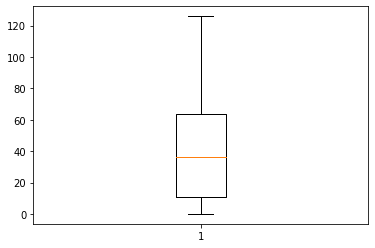

In [21]:
plt.boxplot(mlb_data_infld["RBI"])

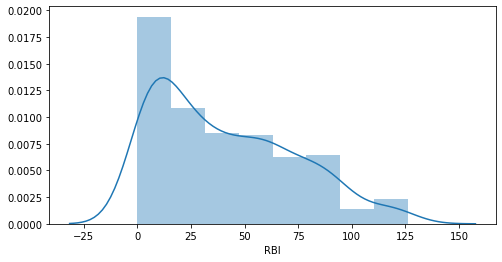

In [34]:
import seaborn as sns
plt.figure(figsize=(8,4))
# plt.xticks(range(0,60,5), rotation=60)
sns.distplot(mlb_data_infld['RBI'])

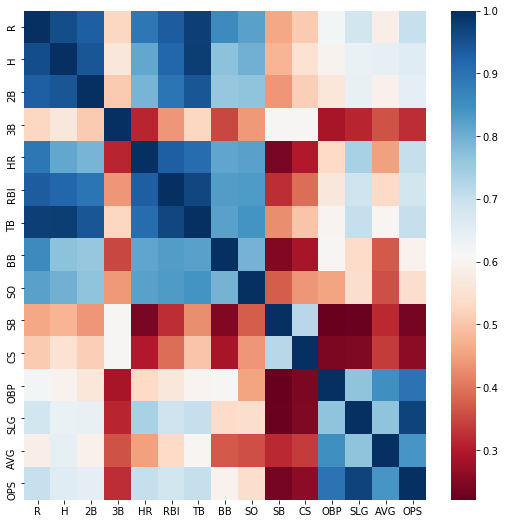

In [35]:
# 이상치 찾아내는 방법
# DataFrame의 corr()를 이용해 피처별로 상관도 구하고 heatmap 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr = mlb_data_infld.corr()
sns.heatmap(corr, cmap="RdBu")

- cmap-"RdBu" 
- 양의 상관관계가 높을 수록 - 진한 파란색
- 음의 상관관계가 높을 수록 - 진한 빨간색

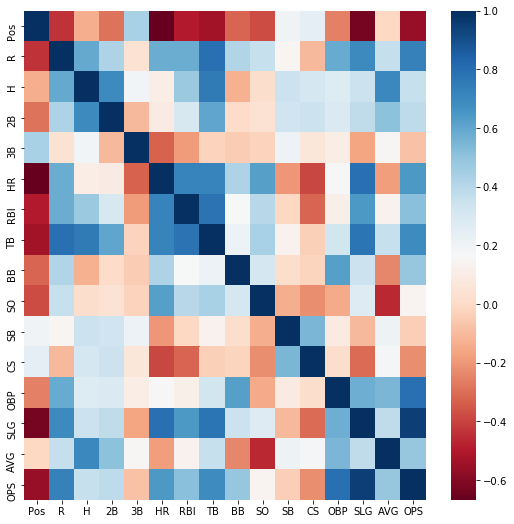

In [56]:
plt.figure(figsize=(9,9))
corr = miner_data_infld.corr()
sns.heatmap(corr, cmap="RdBu")

# 데이터 레이블 및 데이터 세트 분리

In [39]:
# label 데이터 레이블 인코딩
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(mlb_data_infld['Pos'])
encoder.fit(miner_data_infld['Pos'])
mlb_data_infld['Pos'] = encoder.transform(mlb_data_infld['Pos'])
miner_data_infld['Pos'] = encoder.transform(miner_data_infld['Pos'])
#labels = labels.reshape(-1, 1)
print(miner_data_infld[:5], "\n", mlb_data_infld[:5])

   Pos   R    H  2B  3B  HR  RBI   TB  BB   SO  SB  CS    OBP    SLG    AVG  \
0    3  75  115  26   4  10   45  179  49   62  12   5  0.429  0.520  0.334   
1    1  56  118  31   0   6   35  167  37   55   3   8  0.387  0.455  0.322   
2    2  60  131  22   4   7   58  182  27   55   4   4  0.353  0.439  0.316   
3    0  87  130  29   0  26   66  237  58  100   2   2  0.402  0.574  0.315   
4    0  81  162  35   1  25   83  274  24  130   2   1  0.344  0.527  0.312   

     OPS  
0  0.949  
1  0.842  
2  0.792  
3  0.976  
4  0.871   
     Pos    R    H  2B  3B  HR  RBI   TB  BB   SO  SB  CS    OBP    SLG    AVG  \
22    2   61  115  23   1  17   62  191  27   49   2   1  0.395  0.572  0.344   
23    3   81  167  32   0  18   56  253  15  109  17   5  0.357  0.508  0.335   
24    1   54  109  20   1   4   28  143  36   29   2   2  0.399  0.439  0.334   
37    3   27   71  13   1   4   23   98  10   49   0   1  0.360  0.456  0.330   
40    1  109  197  33   2  26  102  312  46   90   5

In [40]:
# 데이터 세트 분리 (피처 데이터 and 라벨 데이터)
y_train = mlb_data_infld['Pos']
x_train = mlb_data_infld.drop('Pos', axis=1)
y_test = miner_data_infld['Pos']
x_test = miner_data_infld.drop('Pos', axis=1)

In [46]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(275, 15) (38, 15)
(275,) (38,)


# 학습하기 
- Machine Learning 모델 생성

In [51]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)
gb_clf = GradientBoostingClassifier(random_state=0)
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.03, max_depth=3)
lgbm_clf = LGBMClassifier(n_estimators=100)

In [52]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [55]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.2895
RF 정확도: 0.3684
DT 정확도: 0.2368
ADA 정확도: 0.2895
GB 정확도: 0.3684
XGB 정확도: 0.3421
LGBM 정확도: 0.3947


# 정규화 : 정확도가 상당히 좋지 않아 "정규화'를 해보자

In [59]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

mean = x_test.mean(axis=0)
x_test -= mean
std = x_test.std(axis=0)
x_test /= std

In [60]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [63]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.4211
RF 정확도: 0.4737
DT 정확도: 0.2895
ADA 정확도: 0.3421
GB 정확도: 0.5000
XGB 정확도: 0.4474
LGBM 정확도: 0.4474


# 정규화 : MinMaxScaler

In [81]:
# 데이터 세트 분리 (피처 데이터 and 라벨 데이터)
y_train = mlb_data_infld['Pos']
x_train = mlb_data_infld.drop('Pos', axis=1)
y_test = miner_data_infld['Pos']
x_test = miner_data_infld.drop('Pos', axis=1)

In [84]:
scaler = MinMaxScaler()
scaler.fit(x_test)
scaler.fit(x_train)
x_test = scaler.transform(x_test)
x_train = scaler.transform(x_train)
print(x_test.shape, x_train.shape)

(38, 15) (275, 15)


In [87]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [88]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [89]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.3158
RF 정확도: 0.3158
DT 정확도: 0.2368
ADA 정확도: 0.2632
GB 정확도: 0.1842
XGB 정확도: 0.3158
LGBM 정확도: 0.2895
